Code based on the example at https://github.com/kach/gradient-descent-the-ultimate-optimizer

In [2]:
!pip install gradient-descent-the-ultimate-optimizer

In [3]:
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from gradient_descent_the_ultimate_optimizer import gdtuo
COLAB=True

In [4]:
SAVEPATH='perparamtests-data/'
PREFIX='CIFAR10-' #'CIFAR10' for CIFAR10, '' for MNIST
if COLAB:
  from google.colab import drive
  SAVEPATH = '/content/drive/MyDrive/Colab Notebooks/' + SAVEPATH
  drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
def save_training_data(train_loss, test_acc, test_loss, name):
  torch.save(train_loss, SAVEPATH+PREFIX+name+"-train-loss.pth")
  torch.save(test_acc, SAVEPATH+PREFIX+name+"-test-acc.pth")
  torch.save(test_loss, SAVEPATH+PREFIX+name+"-test-loss.pth")

def load_training_data(name):
  train_loss = torch.load(SAVEPATH+PREFIX+name+"-train-loss.pth")
  test_acc = torch.load(SAVEPATH+PREFIX+name+"-test-acc.pth")
  test_loss = torch.load(SAVEPATH+PREFIX+name+"-test-loss.pth")
  return train_loss, test_acc, test_loss

In [10]:
#Code adapted from gdtuo implementation of SGD
class SGDExp(gdtuo.Optimizable):
    '''
    A hyperoptimizable SGD.
    '''
    def __init__(self, alpha=0.01, mu=0.0, optimizer=gdtuo.NoOpOptimizer(), exp=False):
        self.mu = mu
        self.state = {}
        self.exp = exp
        parameters = {
            'alpha': torch.tensor(alpha),
            'mu': torch.tensor(mu)
        }
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if self.mu != 0.0:
                if name not in self.state:
                    buf = self.state[name] = g
                else:
                    buf = self.state[name].detach()
                    buf = buf * self.parameters['mu'] + g
                g = self.state[name] = buf
            if self.exp:
              params[name] = p - g * self.parameters['alpha'].exp()
            else:
              params[name] = p - g * self.parameters['alpha']

    def __str__(self):
        return 'sgd / '+ str(self.optimizer)

In [11]:
#Have a different learning rate for each layer
class SGDLayerWise(gdtuo.Optimizable):
    '''
    Optimizes parameters with SGD using one learning rate per parameter tensor.
    '''
    def __init__(self, params, lr0=0.1, optimizer=gdtuo.NoOpOptimizer(), device='cpu'):
        parameters = {k + '_alpha' : torch.tensor([lr0], requires_grad=True).to(device) for k, v in params}
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if name + '_alpha' not in self.parameters: params[name] = p
            else: params[name] = p - g * self.parameters[name + '_alpha'].exp()

    def __str__(self):
        return 'SGDLayerWise / ' + str(self.optimizer)

In [12]:
class SGDParamWise(gdtuo.Optimizable):
    '''
    Optimizes parameters with SGD using one learning rate per parameter
    (effectively doubles the number of learnable parameters).
    '''
    def __init__(self, params, lr0=0.1, optimizer=gdtuo.NoOpOptimizer(), device='cpu'):
        parameters = {k + '_alpha' : lr0 * torch.ones_like(v).to(device)
                      for k, v in params}
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if name + '_alpha' not in self.parameters: params[name] = p
            else: params[name] = p - g * self.parameters[name + '_alpha'].exp()

    def __str__(self):
        return 'SGDLayerWise / ' + str(self.optimizer)

In [13]:
class MNIST_CNN(nn.Module):
     def __init__(self, poly_act):
         super(MNIST_CNN, self).__init__()
         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
         self.dropout1 = nn.Dropout2d(0.25)
         self.dropout2 = nn.Dropout2d(0.5)
         self.fc1 = nn.Linear(12544, 128)  # Adjusted input dimensions
         self.fc2 = nn.Linear(128, 10)
         self.bn1 = nn.BatchNorm2d(1)
         self.bn2 = nn.BatchNorm2d(32)
         self.bn3 = nn.BatchNorm1d(128)

         self.poly_act = poly_act
         self.dict_stats = {}
         self.gather_stats = False

     def forward(self, x):
         x = self.bn1(x)
         x = self.conv1(x)
         if self.gather_stats:
             self.dict_stats['conv1_mean'] = x.clone().detach().cpu().numpy().mean()
             self.dict_stats['conv1_std'] = x.clone().detach().cpu().numpy().std()
         x = self.poly_act(x)

         x = self.bn2(x)
         x = self.conv2(x)
         if self.gather_stats:
             self.dict_stats['conv2_mean'] = x.clone().detach().cpu().numpy().mean()
             self.dict_stats['conv2_std'] = x.clone().detach().cpu().numpy().std()
         x = self.poly_act(x)
         x = F.max_pool2d(x, 2)
         x = self.dropout1(x)
         x = torch.flatten(x, 1)

         x = self.fc1(x)
         x = self.bn3(x)
         if self.gather_stats:
             self.dict_stats['fc1_mean'] = x.clone().detach().cpu().numpy().mean()
             self.dict_stats['fc1_std'] = x.clone().detach().cpu().numpy().std()
         x = self.poly_act(x)
         x = self.dropout2(x)
         x = self.fc2(x)
         output = F.log_softmax(x, dim=1)
         return output

In [ ]:
#Create the model and load the data
class MNIST_FullyConnected(nn.Module):
    """
    A fully-connected NN for the MNIST task. This is Optimizable but not itself
    an optimizer.
    """
    def __init__(self, num_inp, num_hid, num_hid2, num_hid3, num_out):
        super(MNIST_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_hid2)
        self.layer3 = nn.Linear(num_hid2, num_hid3)
        self.layer4 = nn.Linear(num_hid3, num_out)


    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer3.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer4.weight, a=math.sqrt(5))

    def forward(self, x):
        """Compute a prediction."""
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = self.layer3(x)
        x = torch.tanh(x)
        x = self.layer4(x)
        x = F.log_softmax(x, dim=1)
        return x

BATCH_SIZE = 256
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
dl_train = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)


In [27]:
##############################
## CIFAR10 Model + Data
##############################

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.channels = channels

    self.conv1 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act2 = nn.LeakyReLU()

  def forward(self, x):
    y = self.conv1(x)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.act2(y)
    return y + x

class CIFAR10_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 24, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(24)
    self.pooling1 = nn.MaxPool2d(2) #Nx24x16x16
    self.res2 = ResidualBlock(24)
    self.pooling2 = nn.MaxPool2d(2) #Nx24x8x8
    self.fc1 = nn.Linear(1536, 128)
    self.fc_act1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.pooling2(x)
    x = self.fc1(x.view(-1, 1536))
    x = self.fc_act1(x)
    x = self.fc2(x)
    return self.act_final(x)

#Load and transform data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

BATCH_SIZE = 256
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


In [15]:
#Test the model
def test(mw):
  with torch.no_grad():
      for features, labels in dl_test:
          if PREFIX=='': #MNIST
            features, labels = torch.reshape(features, (-1, 28 * 28)).to(DEVICE), labels.to(DEVICE)
          else: #CIFAR10
            features, labels = features.to(DEVICE), labels.to(DEVICE)
          pred = mw.forward(features)
          loss = F.nll_loss(pred, labels, reduction='sum')
          pred = torch.argmax(pred, dim=1)
          print("TEST ACCURACY: {}".format((pred == labels).sum().item() / len(labels)))
          break
  return (pred == labels).sum().item() / len(labels), loss / len(labels)

In [16]:
#Training loop
def train(mw, record_data=False):
  #Store data about the training progress
  train_losses = []
  test_acc = []
  test_loss = []

  for i in range(1, EPOCHS+1):
      running_loss = 0.0
      for n, v in mw.optimizer.parameters.items():
          print(f"Learning rates : {n} : mean={v.mean().item()}, std={v.std().item()}, \
          min={v.min().item()}, max={v.max().item()}")
      for j, (features_, labels_) in enumerate(dl_train):
          mw.begin() # call this before each step, enables gradient tracking on desired params
          #features, labels = torch.reshape(features_, (-1, 28 * 28)).to(DEVICE), labels_.to(DEVICE)
          features, labels = features_.to(DEVICE), labels_.to(DEVICE)
          pred = mw.forward(features)
          loss = F.nll_loss(pred, labels)
          mw.zero_grad()
          loss.backward(create_graph=True) # important! use create_graph=True
          mw.step()

          running_loss += loss.item() * features_.size(0)
          if record_data:
            train_losses.append(loss.item())


      train_loss = running_loss / len(dl_train.dataset)

      print("EPOCH: {}, TRAIN LOSS: {}".format(i, train_loss))
      if record_data:
        acc, l = test(mw)
        test_acc.append(acc)
        test_loss.append(l.item())
  return train_losses, test_acc, test_loss

In [64]:
#model_vanilla = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model_vanilla = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim_vanilla = gdtuo.SGD(alpha=math.exp(-4.0))
mw_vanilla = gdtuo.ModuleWrapper(model_vanilla, optimizer=optim_vanilla)
mw_vanilla.initialize()

train_loss, test_acc, test_loss = train(mw_vanilla, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGD")

Learning rates : alpha : mean=0.018315639346837997, std=nan,           min=0.018315639346837997, max=0.018315639346837997
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 1, TRAIN LOSS: 2.0160547341156008
TEST ACCURACY: 0.4375
Learning rates : alpha : mean=0.018315639346837997, std=nan,           min=0.018315639346837997, max=0.018315639346837997
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 1.6486592963409423
TEST ACCURACY: 0.515625
Learning rates : alpha : mean=0.018315639346837997, std=nan,           min=0.018315639346837997, max=0.018315639346837997
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 1.4784518793487549
TEST ACCURACY: 0.5703125
Learning rates : alpha : mean=0.018315639346837997, std=nan,           min=0.018315639346837997, max=0.018315639346837997
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 1.365077887763977
TEST A

In [32]:
#model_exp = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model_exp = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim_exp = SGDExp(alpha=-4.0, exp=True, optimizer=gdtuo.SGD(0.1))
mw_exp = gdtuo.ModuleWrapper(model_exp, optimizer=optim_exp)
mw_exp.initialize()

train_loss, test_acc, test_loss = train(mw_exp, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGDExp-SGD")

Learning rates : alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH: 1, TRAIN LOSS: 1.9736975043487548
TEST ACCURACY: 0.40625
Learning rates : alpha : mean=-4.277705192565918, std=nan,           min=-4.277705192565918, max=-4.277705192565918
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 1.6589609628677369
TEST ACCURACY: 0.46875
Learning rates : alpha : mean=-4.945493698120117, std=nan,           min=-4.945493698120117, max=-4.945493698120117
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 1.5458078615951538
TEST ACCURACY: 0.5
Learning rates : alpha : mean=-5.386719226837158, std=nan,           min=-5.386719226837158, max=-5.386719226837158
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 1.4824364135742187
TEST ACCURACY: 0.5546875
Learning rates : alpha : mean=-5.686621189117432, std=nan,           min=-5.686621189117432, max=-5.686621189117432
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 5, 

In [28]:
#model = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
#optim = gdtuo.SGD(alpha=0.1, optimizer=gdtuo.NoOpOptimizer())
optim = gdtuo.SGD(alpha=math.exp(-4.0), optimizer=gdtuo.SGD(0.0001))
mw = gdtuo.ModuleWrapper(model, optimizer=optim)
mw.initialize()

train_loss, test_acc, test_loss = train(mw, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGD-SGD")

Learning rates : alpha : mean=0.018315639346837997, std=nan,           min=0.018315639346837997, max=0.018315639346837997
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 1, TRAIN LOSS: 2.014202059020996
TEST ACCURACY: 0.40625
Learning rates : alpha : mean=0.008793050423264503, std=nan,           min=0.008793050423264503, max=0.008793050423264503
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 1.7244218189239502
TEST ACCURACY: 0.4453125
Learning rates : alpha : mean=0.001450069947168231, std=nan,           min=0.001450069947168231, max=0.001450069947168231
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 1.6756520807266235
TEST ACCURACY: 0.4140625
Learning rates : alpha : mean=0.0024793536867946386, std=nan,           min=0.0024793536867946386, max=0.0024793536867946386
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 1.6475705136871337
T

In [29]:
#model2 = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model2 = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim2 = SGDLayerWise(model2.named_parameters(), -4.0, optimizer=gdtuo.SGD(0.1), device=DEVICE)
mw2 = gdtuo.ModuleWrapper(model2, optimizer=optim2)
mw2.initialize()

train_loss, test_acc, test_loss = train(mw2, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGDLW-SGD")

Learning rates : conv1.weight_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : conv1.bias_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res1.conv1.weight_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res1.conv1.bias_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res1.conv2.weight_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res1.conv2.bias_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res2.conv1.weight_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res2.conv1.bias_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res2.conv2.weight_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : res2.conv2.bias_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates : fc1.weight_alpha : mean=-4.0, std=nan,           min=-4.0, max=-4.0
Learning rates 

In [62]:
#model3 = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)
model3 = CIFAR10_CNN().to(DEVICE)

#Create the optimizer
optim3 = SGDParamWise(model3.named_parameters(), -2.0, optimizer=gdtuo.SGD(1.0), device=DEVICE)
mw3 = gdtuo.ModuleWrapper(model3, optimizer=optim3)
mw3.initialize()

train_loss, test_acc, test_loss = train(mw3, record_data=True)
save_training_data(train_loss, test_acc, test_loss, "SGDPW-SGD")

Learning rates : conv1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : conv1.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv1.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv2.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res1.conv2.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv1.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv2.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : res2.conv2.bias_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates : fc1.weight_alpha : mean=-2.0, std=0.0,           min=-2.0, max=-2.0
Learning rates 

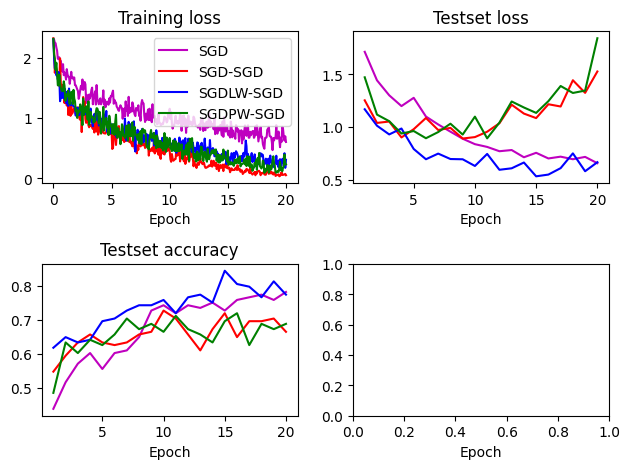

In [65]:
#Create a graph comparing performances of optimizers
trloss0, acc0, loss0 = load_training_data("SGD")
trloss1, acc1, loss1 = load_training_data("SGD-SGD")
trloss2, acc2, loss2 = load_training_data("SGDLW-SGD")
trloss3, acc3, loss3 = load_training_data("SGDPW-SGD")
sample_freq = 25 #only plot every x-th sample
trloss0 = trloss0[::sample_freq]
trloss1 = trloss1[::sample_freq]
trloss2 = trloss2[::sample_freq]
trloss3 = trloss3[::sample_freq]
trdata_x = torch.linspace(0, len(acc1), len(trloss1))

fig, axs = plt.subplots(2, 2)
axs[0][0].set_title("Training loss")
axs[0][0].plot(trdata_x, trloss0, color='m', label='SGD')
axs[0][0].plot(trdata_x, trloss1, color='r', label='SGD-SGD')
axs[0][0].plot(trdata_x, trloss2, color='b', label='SGDLW-SGD')
axs[0][0].plot(trdata_x, trloss3, color='g', label='SGDPW-SGD')
axs[0][0].legend()

axs[0][1].set_title("Testset loss")
axs[0][1].plot(range(1, len(loss0)+1), loss0, color='m', label='SGD')
axs[0][1].plot(range(1, len(loss1)+1), loss1, color='r', label='SGD-SGD')
axs[0][1].plot(range(1, len(loss2)+1), loss2, color='b', label='SGDLW-SGD')
axs[0][1].plot(range(1, len(loss3)+1), loss3, color='g', label='SGDPW-SGD')
#axs[0][1].legend()

axs[1][0].set_title("Testset accuracy")
axs[1][0].plot(range(1, len(acc0)+1), acc0, color='m', label='SGD')
axs[1][0].plot(range(1, len(acc1)+1), acc1, color='r', label='SGD-SGD')
axs[1][0].plot(range(1, len(acc2)+1), acc2, color='b', label='SGDLW-SGD')
axs[1][0].plot(range(1, len(acc3)+1), acc3, color='g', label='SGDPW-SGD')
#axs[1][0].legend()

for ax in axs.flatten():
  ax.set_xlabel("Epoch")

fig.tight_layout()
plt.show()



SGD-SGD 3910 10 10
SGDExp-SGD 3910 10 10
SGDLW-SGD 3910 10 10


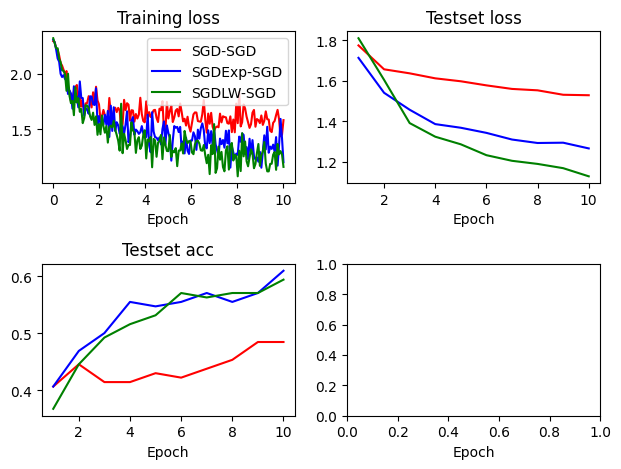

In [33]:
def plot_comparison(names):
  '''
  names : list of names
  '''
  colors = ['r', 'b', 'g', 'm', 'y', 'TOOMANYCOLORS']
  trlosses = []
  accs = []
  losses = []
  sample_freq = 25
  for n in names:
    t, a, l = load_training_data(n)
    trlosses.append(t[::sample_freq])
    accs.append(a)
    losses.append(l)
    print(n, len(t), len(a), len(l))


  fig, axs = plt.subplots(2, 2)
  trdata_x = torch.linspace(0, len(accs[0]), len(trlosses[0]))
  axs[0][0].set_title("Training loss")
  axs[0][1].set_title("Testset loss")
  axs[1][0].set_title("Testset acc")
  for n, t, a, l, c in zip(names, trlosses, accs, losses, colors):
    axs[0][0].plot(trdata_x, t, color=c, label=n)
    axs[0][1].plot(range(1, len(l)+1), l, color=c)
    axs[1][0].plot(range(1, len(a)+1), a, color=c)

  axs[0][0].legend()

  for ax in axs.flatten():
    ax.set_xlabel("Epoch")

  fig.tight_layout()
  plt.show()


plot_comparison(["SGD-SGD", "SGDExp-SGD", "SGDLW-SGD"])
